In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset,DataLoader
from torchvision.datasets.folder import pil_loader
import torchvision.transforms as transforms
from torchvision import datasets, transforms
import time
import copy
import numpy as np
import torch.nn.utils.prune as prune
from prettytable import PrettyTable
import sklearn.metrics
import argparse
import tqdm as tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    #print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params


def get_params(model, method="conv"):
    total_params = 0.0
    instance_obj = torch.nn.Conv2d if method == "conv" else torch.nn.Linear
    for module_name, module in model.named_modules():
        if isinstance(module, instance_obj):
            for param_name, param in module.named_parameters():
                total_params += param.nelement()

    return total_params


def get_percentage(model, percentage, method="global"):
    params_count_total = count_parameters(model)
    number_weights_to_prune = float(percentage * params_count_total)
    #print(number_weights_to_prune)
    if method == "global":
        return percentage
    param_count = get_params(model, method)
    percentage = number_weights_to_prune / param_count
    if percentage > 1.0:
        print(f"Percentage exceeds the parameter count")
    return float(percentage)


def compute_final_pruning_rate(pruning_rate, num_iterations):
    """A function to compute the final pruning rate for iterative pruning.
        Note that this cannot be applied for global pruning rate if the pruning rate is heterogeneous among different layers.

    Args:
        pruning_rate (float): Pruning rate.
        num_iterations (int): Number of iterations.

    Returns:
        float: Final pruning rate.
    """

    final_pruning_rate = 1 - (1 - pruning_rate) ** num_iterations

    return final_pruning_rate


def measure_module_sparsity(module, weight=True, bias=False, use_mask=False):
    num_zeros = 0
    num_elements = 0

    if use_mask == True:
        for buffer_name, buffer in module.named_buffers():
            if "weight_mask" in buffer_name and weight == True:
                num_zeros += torch.sum(buffer == 0).item()
                num_elements += buffer.nelement()
            if "bias_mask" in buffer_name and bias == True:
                num_zeros += torch.sum(buffer == 0).item()
                num_elements += buffer.nelement()
    else:
        for param_name, param in module.named_parameters():
            if "weight" in param_name and weight == True:
                num_zeros += torch.sum(param == 0).item()
                num_elements += param.nelement()
            if "bias" in param_name and bias == True:
                num_zeros += torch.sum(param == 0).item()
                num_elements += param.nelement()

    sparsity = num_zeros / num_elements

    return num_zeros, num_elements, sparsity


def measure_global_sparsity(model,
                            weight=True,
                            bias=False,
                            conv2d_use_mask=False,
                            linear_use_mask=False):
    num_zeros = 0
    num_elements = 0

    for module_name, module in model.named_modules():

        if isinstance(module, torch.nn.Conv2d):

            module_num_zeros, module_num_elements, _ = measure_module_sparsity(
                module, weight=weight, bias=bias, use_mask=conv2d_use_mask)
            num_zeros += module_num_zeros
            num_elements += module_num_elements

        elif isinstance(module, torch.nn.Linear):

            module_num_zeros, module_num_elements, _ = measure_module_sparsity(
                module, weight=weight, bias=bias, use_mask=linear_use_mask)
            num_zeros += module_num_zeros
            num_elements += module_num_elements

    sparsity = num_zeros / num_elements

    return num_zeros, num_elements, sparsity

In [ ]:
!unzip '/content/drive/MyDrive/Deep Learning beyond Accuracy/Pruning/UTK_Big.zip'

Streaming output truncated to the last 5000 lines.
  inflating: UTK_Big/train/2_1_0_20170109190516025.jpg.chip.jpg  
  inflating: __MACOSX/UTK_Big/train/._2_1_0_20170109190516025.jpg.chip.jpg  
  inflating: UTK_Big/train/51_0_0_20170111171747325.jpg.chip.jpg  
  inflating: __MACOSX/UTK_Big/train/._51_0_0_20170111171747325.jpg.chip.jpg  
  inflating: UTK_Big/train/35_1_3_20170104234658417.jpg.chip.jpg  
  inflating: __MACOSX/UTK_Big/train/._35_1_3_20170104234658417.jpg.chip.jpg  
  inflating: UTK_Big/train/26_1_4_20170105164223948.jpg.chip.jpg  
  inflating: __MACOSX/UTK_Big/train/._26_1_4_20170105164223948.jpg.chip.jpg  
  inflating: UTK_Big/train/28_0_4_20170116002326539.jpg.chip.jpg  
  inflating: __MACOSX/UTK_Big/train/._28_0_4_20170116002326539.jpg.chip.jpg  
  inflating: UTK_Big/train/61_0_1_20170117193626228.jpg.chip.jpg  
  inflating: __MACOSX/UTK_Big/train/._61_0_1_20170117193626228.jpg.chip.jpg  
  inflating: UTK_Big/train/61_0_0_20170111171747565.jpg.chip.jpg  
  inflating: _

In [ ]:
class UTKFace(Dataset):
    r"""
    - Parts of the code from: github.com/narumiruna/UTKFace-utils
    - UTKFace dataset can be found here: https://susanqq.github.io/UTKFace
    - [age] is an integer from 0 to 116, indicating the age
    - [gender] is either 0 (male) or 1 (female)
    - [race] is an integer from 0 to 4, denoting White, Black, Asian, Indian, and Others
    """

    def __init__(self, image_size=224, root="/content/UTK_Small/train/", transform=None):
        self.root = root
        if transform is None:
            transform = transforms.Compose([
                transforms.Resize(size=(image_size, image_size)),
                transforms.ToTensor(),
                transforms.Lambda(lambda t: t.mul(2).sub(1)),  # From [0,1] to [-1,1]
            ])
        self.transform = transform
        self.images_path = os.listdir(root)

    def __getitem__(self, index):
        image_path = self.images_path[index]
        str_list = os.path.basename(image_path).split('.')[0].strip().split('_')
        label = str_list[2]
        image = pil_loader(os.path.join(self.root,image_path))
        image = self.transform(image)
        label = int(label)
        if label > 4:
          label = 0
        return image, label

    def __len__(self):
        return len(self.images_path)

In [ ]:
def one_shot_pruning(model,
                     train_loader,
                     test_loader,
                     device,
                     percentage,
                     model_filepath,
                     method="global",
                     epochs=20):
    parameters_to_prune = []
    conv_mask = False
    linear_mask = False
    if method == "global":
        for module_name, module in model.named_modules():
            if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear):
              parameters_to_prune.append((module, "weight"))
        conv_mask = True
        linear_mask = True

    elif method == "conv":
        for module_name, module in model.named_modules():
            if isinstance(module, torch.nn.Conv2d):
                parameters_to_prune.append((module, "weight"))
        conv_mask = True
    else:
        for module_name, module in model.named_modules():
            if isinstance(module, torch.nn.Linear):
                parameters_to_prune.append((module, "weight"))
        linear_mask = True

    percentage = get_percentage(model, percentage, method=method)
    prune.global_unstructured(
        parameters_to_prune,
        pruning_method=prune.L1Unstructured,
        amount=percentage,
    )

    _, eval_accuracy,confusion_matrix = evaluate_model(model=model,
                                      test_loader=test_loader,
                                      device=device,
                                      criterion=None)

    classification_report = create_classification_report(
        model=model, test_loader=test_loader, device=device)

    num_zeros, num_elements, sparsity = measure_global_sparsity(
        model,
        weight=True,
        bias=False,
        conv2d_use_mask=conv_mask,
        linear_use_mask=linear_mask)

    print("Test Accuracy after pruning : {:.3f}".format(eval_accuracy))
    print("Classification Report after Pruning :")
    print(classification_report)
    print(f"---------------------------------------------------------------")
    print(f"Per class Accuracy on Test Dataset from the untrained pruned model")
    print(confusion_matrix.diag()/confusion_matrix.sum(1))
    print("Global Sparsity: after one shot pruning")
    print("{:.2f}".format(sparsity))
    print(f"Number of masked weights (zeros) after pruning {num_zeros}")


    print(f"--------------------Training after pruning---------------------")
    model = train_model(model, train_loader=train_loader, test_loader=test_loader,device=device,num_epochs=epochs,model_filepath=model_filepath)
    print(f"---------------------------------------------------------------")
    print(f"------------Evaluation after prurning--------------------")
    _, eval_accuracy,confusion_matrix = evaluate_model(model=model,
                                      test_loader=test_loader,
                                      device=device,
                                      criterion=None)
    print(f"Per class Accuracy on Test Dataset from the trained pruned model")
    print(confusion_matrix.diag()/confusion_matrix.sum(1))
    classification_report = create_classification_report(
        model=model, test_loader=test_loader, device=device)

    print("Test Accuracy after pruning and training : {:.3f}".format(eval_accuracy))
    print("Classification Report after Pruning and finetuning :")
    print(classification_report)
    return model


In [ ]:
class Custom_Resnet(nn.Module):
  def __init__(self, num_classes=5) -> None:
      super().__init__()
      self.model = torchvision.models.resnet18()
      self.model.fc = nn.Linear(512,4096)
      self.new_layer = nn.Sequential(nn.Linear(4096,4096,bias=True),nn.Linear(4096,num_classes,bias=True))
      self.model = nn.Sequential(self.model,self.new_layer)

  def forward(self,input):
    return self.model(input)


model = Custom_Resnet()

In [ ]:
def remove_parameters(model):
    for module_name, module in model.named_modules():
        if isinstance(module, torch.nn.Conv2d):
            try:
                prune.remove(module, "weight")
            except:
                pass
            try:
                prune.remove(module, "bias")
            except:
                pass
        elif isinstance(module, torch.nn.Linear):
            try:
                prune.remove(module, "weight")
            except:
                pass
            try:
                prune.remove(module, "bias")
            except:
                pass

    return model


def evaluate_model(model, test_loader, device, criterion=None):
    model.eval()
    model.to(device)
    nb_classes = 5
    confusion_matrix = torch.zeros(nb_classes, nb_classes)
    running_loss = 0
    running_corrects = 0
    with torch.no_grad():
      for inputs, labels in test_loader:

          inputs = inputs.to(device)
          labels = labels.to(device)

          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)

          if criterion is not None:
              loss = criterion(outputs, labels).item()
          else:
              loss = 0

          # statistics
          running_loss += loss * inputs.size(0)
          running_corrects += torch.sum(preds == labels.data)

          for t, p in zip(labels.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

    eval_loss = running_loss / len(test_loader.dataset)
    eval_accuracy = running_corrects / len(test_loader.dataset)
    return eval_loss, eval_accuracy,confusion_matrix


def create_classification_report(model, device, test_loader):
    model.eval()
    model.to(device)

    y_pred = []
    y_true = []

    with torch.no_grad():
        for data in test_loader:
            y_true += data[1].numpy().tolist()
            images, _ = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            y_pred += predicted.cpu().numpy().tolist()

    classification_report = sklearn.metrics.classification_report(
        y_true=y_true, y_pred=y_pred)

    return classification_report


def train_model(model,
                train_loader,
                test_loader,
                device,
                model_filepath,
                l1_regularization_strength=0,
                l2_regularization_strength=1e-4,
                learning_rate=1e-1,
                num_epochs=20):
    # The training configurations were not carefully selected.

    criterion = nn.CrossEntropyLoss()
    best_val_accuracy = 0.0
    model.to(device)

    # It seems that SGD optimizer is better than Adam optimizer for ResNet18 training on CIFAR10.
    optimizer = optim.SGD(model.parameters(),
                          lr=learning_rate)
    # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=500)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,
                                                     milestones=[10, 15],
                                                     gamma=0.1,
                                                     last_epoch=-1)

    for epoch in range(num_epochs):

        # Training
        model.train()

        running_loss = 0
        running_corrects = 0

        for inputs,labels in train_loader:
            # input,labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        train_loss = running_loss / len(train_loader.dataset)
        train_accuracy = running_corrects / len(train_loader.dataset)
        # Evaluation
        model.eval()
        eval_loss, eval_accuracy,confusion_matrix = evaluate_model(model=model,
                                                  test_loader=test_loader,
                                                  device=device,
                                                  criterion=criterion)

        if eval_accuracy > best_val_accuracy:
          best_val_accuracy = eval_accuracy
          torch.save(model.state_dict(),model_filepath)
        # Set learning rate scheduler
        scheduler.step()

        print(
            "Epoch: {:03d} Train Loss: {:.3f} Train Acc: {:.3f} Eval Loss: {:.3f} Eval Acc: {:.3f}"
                .format(epoch + 1, train_loss, train_accuracy, eval_loss,
                        eval_accuracy))

        print(f"Per class Accuracy on Test Dataset")
        print(confusion_matrix.diag()/confusion_matrix.sum(1))
        print(f"---------------------------------------------------------------")
    return model


def save_model(model, model_dir, model_filename):
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    model_filepath = os.path.join(model_dir, model_filename)
    torch.save(model.state_dict(), model_filepath)


def load_model(model, model_filepath, device):
    model.load_state_dict(torch.load(model_filepath, map_location=device))

    return model


def create_model(num_classes=5, model_func=torchvision.models.vgg16):
    # The number of channels in ResNet18 is divisible by 8.
    # This is required for fast GEMM integer matrix multiplication.
    # model = torchvision.models.resnet18(pretrained=False)
    model = torchvision.models.resnet18(pretrained=False)
    # model.classifier[-1] = nn.Linear(in_features=4096, out_features=num_classes)

    # We would use the pretrained ResNet18 as a feature extractor.
    # for param in model.parameters():
    #     param.requires_grad = False

    # Modify the last FC layer
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)

    return model


In [ ]:
def set_dataloaders():
  transform_train = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.Resize(size=(256,256)),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    transform_val = transforms.Compose([
        transforms.Resize(size=(256,256)),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    train_dataset = UTKFace(root='/content/UTK_Big/train', transform=transform_train)
    val_dataset = UTKFace(root='/content/UTK_Big/test',transform = transform_val)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True)

    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=16)

    return train_loader,val_loader,train_dataset,val_dataset

In [ ]:
def set_hyperparameters():
  num_classes = 5
  random_seed = 1
  l1_regularization_strength = 0
  l2_regularization_strength = 1e-4
  learning_rate = 1e-3
  learning_rate_decay = 1
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
prune_percentage = 0.5
batch_size = 32
epochs = 20
method = "linear"
def main():

    num_classes = 5
    random_seed = 1
    l1_regularization_strength = 0
    l2_regularization_strength = 1e-4
    learning_rate = 1e-3
    learning_rate_decay = 1

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model_dir = "/content/drive/MyDrive/Deep Learning beyond Accuracy/Pruning/saved_models"
    model_filename = "resnet18_utk"
    model_filename += ".pth"
    pruned_model_filename = "pruned_model_" + str(prune_percentage) + "_" + method +"_"+ model_filename
    model_filepath = os.path.join(model_dir, model_filename)
    pruned_model_filepath = os.path.join(model_dir, pruned_model_filename)

    # set_random_seeds(random_seed=random_seed)
    transform_train = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.Resize(size=(256,256)),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    transform_val = transforms.Compose([
        transforms.Resize(size=(256,256)),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    train_dataset = UTKFace(root='/content/UTK_Big/train', transform=transform_train)
    val_dataset = UTKFace(root='/content/UTK_Big/test',transform = transform_val)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True)

    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=16)
    # Create an untrained model.
    model = Custom_Resnet()
    print(f"---------------training a unpruned model------------------------")
    model = train_model(model, train_loader=train_loader, test_loader=val_loader, model_filepath=model_filepath,device=device, num_epochs=epochs)

    _, eval_accuracy,confusion_matrix = evaluate_model(model=model,
                                      test_loader=val_loader,
                                      device=device,
                                      criterion=None)


    print(f"Per class Accuracy on Test Dataset from the trained unpruned model")
    print(confusion_matrix.diag()/confusion_matrix.sum(1))
    print(f"---------------------------------------------------------------")
    classification_report = create_classification_report(
        model=model, test_loader=val_loader, device=device)

    num_zeros, num_elements, sparsity = measure_global_sparsity(model)

    print("Test Accuracy before pruning: {:.3f}".format(eval_accuracy))
    print("Classification Report before pruning:")
    print(classification_report)
    print("Global Sparsity before pruning:")
    print("{:.2f}".format(sparsity))

    # torch.save(model.state_dict(), model_filepath)
    print("One Shot Pruning")
    pruned_model = copy.deepcopy(model)
    pruned_model = one_shot_pruning(pruned_model, train_loader, val_loader, device, prune_percentage,method=method,epochs = epochs,model_filepath=pruned_model_filepath)
    #torch.save(pruned_model.state_dict(),pruned_model_filepath)


In [ ]:
main()

---------------training a unpruned model------------------------
Epoch: 001 Train Loss: 1.244 Train Acc: 0.543 Eval Loss: 1.156 Eval Acc: 0.555
Per class Accuracy on Test Dataset
tensor([0.7623, 0.7919, 0.5381, 0.3519, 0.0000])
---------------------------------------------------------------
Epoch: 002 Train Loss: 0.856 Train Acc: 0.690 Eval Loss: 1.258 Eval Acc: 0.544
Per class Accuracy on Test Dataset
tensor([0.6100, 0.9364, 0.4056, 0.5278, 0.0000])
---------------------------------------------------------------
Epoch: 003 Train Loss: 0.727 Train Acc: 0.745 Eval Loss: 1.900 Eval Acc: 0.454
Per class Accuracy on Test Dataset
tensor([0.4322, 0.7110, 0.9454, 0.0787, 0.0108])
---------------------------------------------------------------
Epoch: 004 Train Loss: 0.649 Train Acc: 0.773 Eval Loss: 0.858 Eval Acc: 0.689
Per class Accuracy on Test Dataset
tensor([0.7887, 0.8613, 0.8642, 0.3951, 0.3699])
---------------------------------------------------------------
Epoch: 005 Train Loss: 0.59

In [ ]:
model = Custom_Resnet()
tot_params = count_parameters(model)
conv_params = get_params(model,method="linear")
print(conv_params)

Total Trainable Params: 30079557
18903045.0


**Global Pruning 50%**

In [ ]:
prune_percentage = 0.50
batch_size = 32
epochs = 20
method = "global"


model_dir = "/content/drive/MyDrive/Deep Learning beyond Accuracy/Pruning/saved_models"
model_filename = "resnet18_utk"
model_filename += ".pth"
pruned_model_filename = "pruned_model_" + str(prune_percentage) + "_" + method +"_"+ model_filename
model_filepath = os.path.join(model_dir, model_filename)
pruned_model_filepath = os.path.join(model_dir, pruned_model_filename)

train_loader,val_loader,train_dataset,val_dataset = set_dataloaders()
# Create an untrained model.
pruned_model = Custom_Resnet()
pruned_model.load_state_dict(torch.load('/content/drive/MyDrive/Deep Learning beyond Accuracy/Pruning/saved_models/resnet18_utk.pth'))
print("One Shot Pruning")
# pruned_model = copy.deepcopy(model)
pruned_model = one_shot_pruning(pruned_model, train_loader, val_loader, device, prune_percentage,method=method,epochs = epochs,model_filepath=pruned_model_filepath)

One Shot Pruning
Total Trainable Params: 30079557
Test Accuracy after pruning : 0.848
Classification Report after Pruning :
              precision    recall  f1-score   support

           0       0.81      0.96      0.88      1136
           1       0.94      0.88      0.91       692
           2       0.93      0.89      0.91       604
           3       0.88      0.77      0.82       648
           4       0.66      0.58      0.62       465

    accuracy                           0.85      3545
   macro avg       0.84      0.82      0.83      3545
weighted avg       0.85      0.85      0.85      3545

---------------------------------------------------------------
Per class Accuracy on Test Dataset from the untrained pruned model
tensor([0.9595, 0.8786, 0.8907, 0.7701, 0.5806])
Global Sparsity: after one shot pruning
0.50
Number of masked weights (zeros) after pruning 15030880
--------------------Training after pruning---------------------
Epoch: 001 Train Loss: 0.259 Train Acc: 0.

In [ ]:
prune_percentage = 0.30
batch_size = 32
epochs = 20
method = "conv"

num_classes = 5
random_seed = 1
l1_regularization_strength = 0
l2_regularization_strength = 1e-4
learning_rate = 1e-3
learning_rate_decay = 1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_dir = "/content/drive/MyDrive/Deep Learning beyond Accuracy/Pruning/saved_models"
model_filename = "resnet18_utk"
model_filename += ".pth"
pruned_model_filename = "pruned_model_" + str(prune_percentage) + "_" + method +"_"+ model_filename
model_filepath = os.path.join(model_dir, model_filename)
pruned_model_filepath = os.path.join(model_dir, pruned_model_filename)

# set_random_seeds(random_seed=random_seed)
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize(size=(256,256)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_val = transforms.Compose([
    transforms.Resize(size=(256,256)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
train_dataset = UTKFace(root='/content/UTK_Big/train', transform=transform_train)
val_dataset = UTKFace(root='/content/UTK_Big/test',transform = transform_val)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=16)
# Create an untrained model.
pruned_model = Custom_Resnet()
pruned_model.load_state_dict(torch.load('/content/drive/MyDrive/Deep Learning beyond Accuracy/Pruning/saved_models/resnet18_utk.pth'))
print("One Shot Pruning")
# pruned_model = copy.deepcopy(model)
pruned_model = one_shot_pruning(pruned_model, train_loader, val_loader, device, prune_percentage,method=method,epochs = epochs,model_filepath=pruned_model_filepath)


One Shot Pruning
Total Trainable Params: 30079557


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Accuracy after pruning : 0.350
Classification Report after Pruning :
              precision    recall  f1-score   support

           0       0.34      0.99      0.50      1136
           1       1.00      0.03      0.06       692
           2       1.00      0.00      0.00       604
           3       0.50      0.15      0.23       648
           4       0.00      0.00      0.00       465

    accuracy                           0.35      3545
   macro avg       0.57      0.23      0.16      3545
weighted avg       0.56      0.35      0.21      3545

---------------------------------------------------------------
Per class Accuracy on Test Dataset from the untrained pruned model
tensor([0.9894, 0.0303, 0.0017, 0.1466, 0.0000])
Global Sparsity: after one shot pruning
0.30
--------------------Training after pruning---------------------
Epoch: 001 Train Loss: 0.385 Train Acc: 0.863 Eval Loss: 0.743 Eval Acc: 0.760
Per class Accuracy on Test Dataset
tensor([0.8794, 0.9133, 0.7467, 0.

**Pruning 10 Million Parameters on the Convolutional Layer**

In [ ]:
prune_percentage = 0.33
batch_size = 32
epochs = 20
method = "conv"

num_classes = 5
random_seed = 1
l1_regularization_strength = 0
l2_regularization_strength = 1e-4
learning_rate = 1e-3
learning_rate_decay = 1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_dir = "/content/drive/MyDrive/Deep Learning beyond Accuracy/Pruning/saved_models"
model_filename = "resnet18_utk"
model_filename += ".pth"
pruned_model_filename = "pruned_model_" + str(prune_percentage) + "_" + method +"_"+ model_filename
model_filepath = os.path.join(model_dir, model_filename)
pruned_model_filepath = os.path.join(model_dir, pruned_model_filename)

# set_random_seeds(random_seed=random_seed)
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize(size=(256,256)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_val = transforms.Compose([
    transforms.Resize(size=(256,256)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
train_dataset = UTKFace(root='/content/UTK_Big/train', transform=transform_train)
val_dataset = UTKFace(root='/content/UTK_Big/test',transform = transform_val)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=16)
# Create an untrained model.
pruned_model = Custom_Resnet()
pruned_model.load_state_dict(torch.load('/content/drive/MyDrive/Deep Learning beyond Accuracy/Pruning/saved_models/resnet18_utk.pth'))
print("One Shot Pruning")
# pruned_model = copy.deepcopy(model)
pruned_model = one_shot_pruning(pruned_model, train_loader, val_loader, device, prune_percentage,method=method,epochs = epochs,model_filepath=pruned_model_filepath)

One Shot Pruning
Total Trainable Params: 30079557


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Accuracy after pruning : 0.320
Classification Report after Pruning :
              precision    recall  f1-score   support

           0       0.32      1.00      0.49      1136
           1       0.00      0.00      0.00       692
           2       0.00      0.00      0.00       604
           3       0.00      0.00      0.00       648
           4       0.00      0.00      0.00       465

    accuracy                           0.32      3545
   macro avg       0.06      0.20      0.10      3545
weighted avg       0.10      0.32      0.16      3545

---------------------------------------------------------------
Per class Accuracy on Test Dataset from the untrained pruned model
tensor([1., 0., 0., 0., 0.])
Global Sparsity: after one shot pruning
0.33
Number of masked weights (zeros) after pruning 9926254
--------------------Training after pruning---------------------
Epoch: 001 Train Loss: nan Train Acc: 0.423 Eval Loss: nan Eval Acc: 0.320
Per class Accuracy on Test Dataset
ten

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Training 10 Million Parameters in the FC Layers**

In [ ]:
prune_percentage = 0.33
batch_size = 32
epochs = 20
method = "linear"

set_hyperparameters()
train_loader,val_loader,train_dataset,val_dataset = set_dataloaders()

model_dir = "/content/drive/MyDrive/Deep Learning beyond Accuracy/Pruning/saved_models"
model_filename = "resnet18_utk"
model_filename += ".pth"
pruned_model_filename = "pruned_model_" + str(prune_percentage) + "_" + method +"_"+ model_filename
model_filepath = os.path.join(model_dir, model_filename)
pruned_model_filepath = os.path.join(model_dir, pruned_model_filename)



# Create an untrained model.
pruned_model = Custom_Resnet()
pruned_model.load_state_dict(torch.load('/content/drive/MyDrive/Deep Learning beyond Accuracy/Pruning/saved_models/resnet18_utk.pth'))
print("One Shot Pruning")
# pruned_model = copy.deepcopy(model)
pruned_model = one_shot_pruning(pruned_model, train_loader, val_loader, device, prune_percentage,method=method,epochs = epochs,model_filepath=pruned_model_filepath)

One Shot Pruning
Total Trainable Params: 30079557
Test Accuracy after pruning : 0.855
Classification Report after Pruning :
              precision    recall  f1-score   support

           0       0.85      0.95      0.90      1136
           1       0.92      0.89      0.90       692
           2       0.91      0.91      0.91       604
           3       0.85      0.80      0.83       648
           4       0.70      0.57      0.63       465

    accuracy                           0.86      3545
   macro avg       0.84      0.82      0.83      3545
weighted avg       0.85      0.86      0.85      3545

---------------------------------------------------------------
Per class Accuracy on Test Dataset from the untrained pruned model
tensor([0.9525, 0.8887, 0.9139, 0.7994, 0.5699])
Global Sparsity: after one shot pruning
0.33
Number of masked weights (zeros) after pruning 9921949
--------------------Training after pruning---------------------
Epoch: 001 Train Loss: 0.310 Train Acc: 0.8

**We now do percentage wise pruning, we prune 90% of the weights in both FC blocks and Conv Blocks.**

**90% of the COnv block translates to 10 Million Paramaters, for which we have obtained the results, now we prune 90% of the FC paramaters, which is roughly 17 Million parameters ~ 56% of the toatal number of parameters**

In [ ]:
prune_percentage = 0.56
batch_size = 32
epochs = 20
method = "linear"

num_classes = 5
random_seed = 1
l1_regularization_strength = 0
l2_regularization_strength = 1e-4
learning_rate = 1e-3
learning_rate_decay = 1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_dir = "/content/drive/MyDrive/Deep Learning beyond Accuracy/Pruning/saved_models"
model_filename = "resnet18_utk"
model_filename += ".pth"
pruned_model_filename = "pruned_model_" + str(prune_percentage) + "_" + method +"_"+ model_filename
model_filepath = os.path.join(model_dir, model_filename)
pruned_model_filepath = os.path.join(model_dir, pruned_model_filename)

# set_random_seeds(random_seed=random_seed)
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize(size=(256,256)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_val = transforms.Compose([
    transforms.Resize(size=(256,256)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
train_dataset = UTKFace(root='/content/UTK_Big/train', transform=transform_train)
val_dataset = UTKFace(root='/content/UTK_Big/test',transform = transform_val)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=16)
# Create an untrained model.
pruned_model = Custom_Resnet()
pruned_model.load_state_dict(torch.load('/content/drive/MyDrive/Deep Learning beyond Accuracy/Pruning/saved_models/resnet18_utk.pth'))
print("One Shot Pruning")
# pruned_model = copy.deepcopy(model)
pruned_model = one_shot_pruning(pruned_model, train_loader, val_loader, device, prune_percentage,method=method,epochs = epochs,model_filepath=pruned_model_filepath)

One Shot Pruning
Total Trainable Params: 30079557
Test Accuracy after pruning : 0.834
Classification Report after Pruning :
              precision    recall  f1-score   support

           0       0.77      0.97      0.86      1136
           1       0.97      0.84      0.90       692
           2       0.97      0.83      0.89       604
           3       0.87      0.78      0.82       648
           4       0.65      0.57      0.60       465

    accuracy                           0.83      3545
   macro avg       0.84      0.80      0.82      3545
weighted avg       0.84      0.83      0.83      3545

---------------------------------------------------------------
Per class Accuracy on Test Dataset from the untrained pruned model
tensor([0.9718, 0.8410, 0.8328, 0.7809, 0.5656])
Global Sparsity: after one shot pruning
0.56
Number of masked weights (zeros) after pruning 16837248
--------------------Training after pruning---------------------
Epoch: 001 Train Loss: 0.267 Train Acc: 0.

# Extracting the Statistics of the Unpruned Custom Model

In [ ]:
unpruned_model = Custom_Resnet()
unpruned_model.load_state_dict(torch.load('/content/drive/MyDrive/Deep Learning beyond Accuracy/Pruning/saved_models/resnet18_utk.pth'))

<All keys matched successfully>

In [ ]:
flattened_weights = []
for param_name,param in unpruned_model.named_parameters():
  if "weight" in param_name:
    flattened_weights.append(param.flatten())

In [ ]:
for i,ele in enumerate(flattened_weights):
  if i==0:
    final_t = ele
  else:
    final_t = torch.cat((final_t,ele))

In [ ]:
abs_vals = torch.abs(final_t)

In [ ]:
final_t = final_t.detach().numpy()
abs_vals = abs_vals.detach().numpy()

In [ ]:
final_t = final_t[np.logical_and(final_t<0.15,final_t>-0.15)]

In [ ]:
abs_vals = abs_vals[abs_vals<0.15]

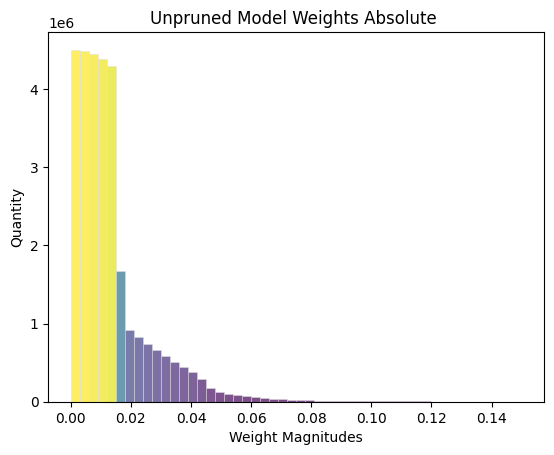

In [ ]:
n, bins, patches = plt.hist(abs_vals, bins=50, facecolor='#2ab0ff', edgecolor='#e0e0e0', linewidth=0.5, alpha=0.7)
plt.title('Unpruned Model Weights Absolute ')
plt.xlabel('Weight Magnitudes')
plt.ylabel('Quantity')
n = n.astype('int') # it MUST be integer
# Good old loop. Choose colormap of your taste
for i in range(len(patches)):
    patches[i].set_facecolor(plt.cm.viridis(n[i]/max(n)))

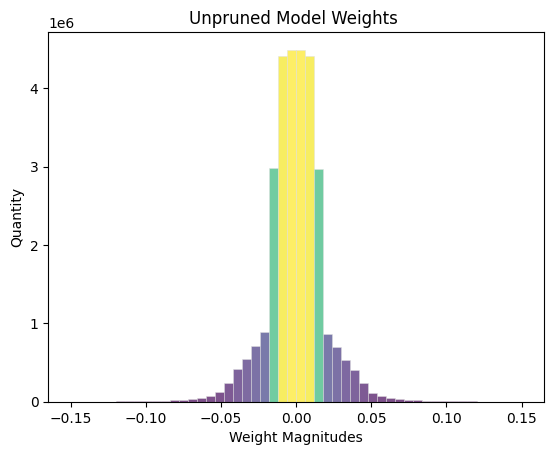

In [ ]:
n, bins, patches = plt.hist(final_t, bins=50, facecolor='#2ab0ff', edgecolor='#e0e0e0', linewidth=0.5, alpha=0.7)
plt.title('Unpruned Model Weights ')
plt.xlabel('Weight Magnitudes')
plt.ylabel('Quantity')
n = n.astype('int') # it MUST be integer
# Good old loop. Choose colormap of your taste
for i in range(len(patches)):
    patches[i].set_facecolor(plt.cm.viridis(n[i]/max(n)))

# Extracting the statistics of the FC Pruned Model

In [ ]:
pruned_model = Custom_Resnet()
pruned_model.load_state_dict(torch.load('/content/drive/MyDrive/Deep Learning beyond Accuracy/Pruning/saved_models/resnet18_utk.pth'))

<All keys matched successfully>

In [ ]:
parameters_to_prune = []
conv_mask = False
linear_mask = False
percentage = 0.5
method = "linear"
if method == "global":
    for module_name, module in pruned_model.named_modules():
        if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear):
          parameters_to_prune.append((module, "weight"))
    conv_mask = True
    linear_mask = True

elif method == "conv":
    for module_name, module in pruned_model.named_modules():
        if isinstance(module, torch.nn.Conv2d):
            parameters_to_prune.append((module, "weight"))
    conv_mask = True
else:
    for module_name, module in pruned_model.named_modules():
        if isinstance(module, torch.nn.Linear):
            parameters_to_prune.append((module, "weight"))
    linear_mask = True

percentage = get_percentage(pruned_model, percentage, method=method)
prune.global_unstructured(
    parameters_to_prune,
    pruning_method=prune.L1Unstructured,
    amount=percentage,
)

Total Trainable Params: 30079557


In [ ]:
torch.save(pruned_model.state_dict(),'/content/drive/MyDrive/Deep Learning beyond Accuracy/Pruning/saved_models_dist/pruned_model_0.5_linear_custom_utk.pth')

In [ ]:
buffer_dict={}
param_dict={}

for buffer_name,buffer in pruned_model.named_buffers():
  if "weight_mask" in buffer_name:
    buffer_dict[buffer_name]=buffer

for param_name,param in pruned_model.named_parameters():
  if "weight_orig" in param_name:
    param_dict[param_name]=param

In [ ]:
pruned_weights = []
for (buffer_name,buffer),(param_name,param) in zip(buffer_dict.items(),param_dict.items()):
  buffer_flattened = buffer.flatten()
  param_flattened = param.flatten()
  buffer_not = torch.logical_not(buffer_flattened)
  buffer_indices = buffer_not.nonzero()
  weights = param_flattened[buffer_indices]
  pruned_weights.append(weights)

In [ ]:
for i,ele in enumerate(pruned_weights):
  if i == 0:
    final_t_pruned = ele
  else:
    final_t_pruned = torch.cat((final_t_pruned,ele))

In [ ]:
abs_vals_pruned = torch.abs(final_t_pruned)

In [ ]:
final_t_pruned = final_t_pruned.detach().numpy()
abs_vals_pruned = abs_vals_pruned.detach().numpy()

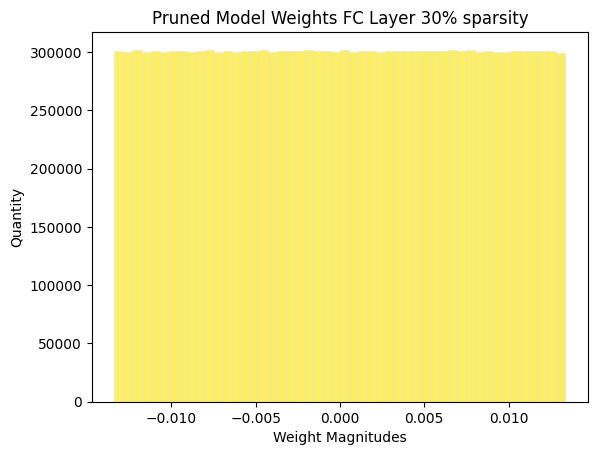

In [ ]:
n, bins, patches = plt.hist(final_t_pruned, bins=50, facecolor='#2ab0ff', edgecolor='#e0e0e0', linewidth=0.5, alpha=0.7)
plt.title('Pruned Model Weights FC Layer 30% sparsity')
plt.xlabel('Weight Magnitudes')
plt.ylabel('Quantity')
n = n.astype('int') # it MUST be integer
# Good old loop. Choose colormap of your taste
for i in range(len(patches)):
    patches[i].set_facecolor(plt.cm.viridis(n[i]/max(n)))

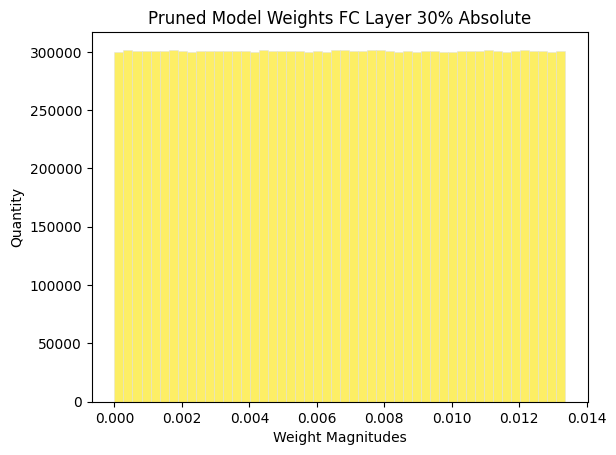

In [ ]:
n, bins, patches = plt.hist(abs_vals_pruned, bins=50, facecolor='#2ab0ff', edgecolor='#e0e0e0', linewidth=0.5, alpha=0.7)
plt.title('Pruned Model Weights FC Layer 30% Absolute')
plt.xlabel('Weight Magnitudes')
plt.ylabel('Quantity')
n = n.astype('int') # it MUST be integer
# Good old loop. Choose colormap of your taste
for i in range(len(patches)):
    patches[i].set_facecolor(plt.cm.viridis(n[i]/max(n)))

# Extracting the statistics of the Conv Pruned Custom Model

In [ ]:
pruned_model_conv = Custom_Resnet()
pruned_model_conv.load_state_dict(torch.load('/content/drive/MyDrive/Deep Learning beyond Accuracy/Pruning/saved_models/resnet18_utk.pth'))

<All keys matched successfully>

In [ ]:
parameters_to_prune = []
conv_mask = False
linear_mask = False
percentage = 0.37
method = "conv"
if method == "global":
    for module_name, module in pruned_model_conv.named_modules():
        if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear):
          parameters_to_prune.append((module, "weight"))
    conv_mask = True
    linear_mask = True

elif method == "conv":
    for module_name, module in pruned_model_conv.named_modules():
        if isinstance(module, torch.nn.Conv2d):
            parameters_to_prune.append((module, "weight"))
    conv_mask = True
else:
    for module_name, module in pruned_model_conv.named_modules():
        if isinstance(module, torch.nn.Linear):
            parameters_to_prune.append((module, "weight"))
    linear_mask = True

percentage = get_percentage(pruned_model_conv, percentage, method=method)
prune.global_unstructured(
    parameters_to_prune,
    pruning_method=prune.L1Unstructured,
    amount=percentage,
)

Total Trainable Params: 30079557


In [ ]:
torch.save(pruned_model_conv.state_dict(),'/content/drive/MyDrive/Deep Learning beyond Accuracy/Pruning/saved_models_dist/pruned_model_0.37_conv_custom_utk.pth')

In [ ]:
buffer_dict={}
param_dict={}

for buffer_name,buffer in pruned_model_conv.named_buffers():
  if "weight_mask" in buffer_name:
    buffer_dict[buffer_name]=buffer

for param_name,param in pruned_model_conv.named_parameters():
  if "weight_orig" in param_name:
    param_dict[param_name]=param

In [ ]:
pruned_weights = []
for (buffer_name,buffer),(param_name,param) in zip(buffer_dict.items(),param_dict.items()):
  buffer_flattened = buffer.flatten()
  param_flattened = param.flatten()
  buffer_not = torch.logical_not(buffer_flattened)
  buffer_indices = buffer_not.nonzero()
  weights = param_flattened[buffer_indices]
  pruned_weights.append(weights)

In [ ]:
for i,ele in enumerate(pruned_weights):
  if i == 0:
    final_t_pruned = ele
  else:
    final_t_pruned = torch.cat((final_t_pruned,ele))

In [ ]:
abs_vals_pruned = torch.abs(final_t_pruned)

In [ ]:
final_t_pruned = final_t_pruned.detach().numpy()
abs_vals_pruned = abs_vals_pruned.detach().numpy()

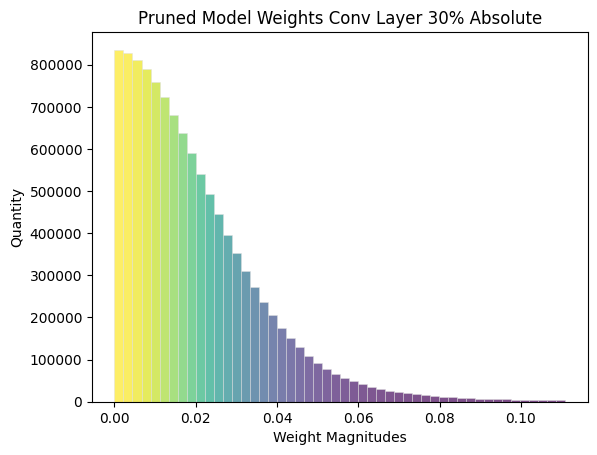

In [ ]:
n, bins, patches = plt.hist(abs_vals_pruned, bins=50, facecolor='#2ab0ff', edgecolor='#e0e0e0', linewidth=0.5, alpha=0.7)
plt.title('Pruned Model Weights Conv Layer 30% Absolute')
plt.xlabel('Weight Magnitudes')
plt.ylabel('Quantity')
n = n.astype('int') # it MUST be integer
# Good old loop. Choose colormap of your taste
for i in range(len(patches)):
    patches[i].set_facecolor(plt.cm.viridis(n[i]/max(n)))